In [1]:

# This is the file to calculate coupling loss 
# In the idea scenario we assume 2 lens are facing exactly centre to centre
# In the misaligned scenario we assume a small angular misalignment is presented at the 1st lens

# 3 types of losses are considered: 
# - lateral offset: the deviation of centre ray of incident beam onto RX fibre 
# - mode size mismatch (however for a 2-lens system w1 should be the same as w0, can be verified by simulation)
# - clipping loss (if significant, also assume the beam core is at centre of lens)



import sys
sys.path.append('..') 

import importlib
import modified_matrix_tracer
importlib.reload(modified_matrix_tracer)

from modified_matrix_tracer import GaussianBeam, FreeSpaceIterator, ThinLens, Misalignment
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from cycler import cycler
import numpy as np
import operator

#sample
Nsamples = 1000
scale = 1e3 #plot in mm



ray_tracing_PlotON = 1

MFD_mode_solver = []



#fibre
SMF28_fibre_para = {
"core_diameter": 8.2e-6,
"core_beam_x0":0,
"core_beam_theta":0,
"NA": 0.14
}

#lens
TC18APC1550_para = {
"focal" : 18.36e-3,
"clear_aperture" : 10e-3,
"outer_diameter" : 14.9e-3,
    "length": 33.5e-3,
#"wavelength_range": np.linspace(1465.0e-9, 1650.0e-9, num=38)
 "wavelength_range": [1465.0e-9, 1550.0e-9, 1648.0e-9],
 "MFD_mode_solver":[9.94746832156340e-6, 10.3988077139997e-6, 10.9710948505490e-6]
}


#10 colour keys
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] 


# We assume that the 2 lenses are ideally facing each other, no matter what actuator angle is
# However, we add small lateral/angular movements to the TX lens to simulate misalignment

#In this scenario we only consider angular misalignment standlone
lateral_misalignment = 0

#must use radians for this matrix_tracer 
angular_misalignment_deg = np.arange(0.0, 0.014, 0.0001)
angular_misalignment = [i*(np.pi/180) for i in angular_misalignment_deg]



In [2]:
# assign colour by X in plots
def assign_colour_cycle_by_xcvr(xx, color_cycle):
    
    if xx  == 0:
        assigned_colour = color_cycle[xx]
    else:
        reminder = xx % len(color_cycle) 
        assigned_colour = color_cycle[reminder]
    return assigned_colour
    
    
    
def plot_arbitrary_lens(radius, angle, centre_coord):
    x0 = centre_coord[0]
    y0 = centre_coord[1]
    plt.plot([x0 - radius*np.sin(angle), x0 + radius*np.sin(angle)], \
             [y0 + radius*np.cos(angle), y0 - radius*np.cos(angle)],'r-')
    

      
#Src: https://www.sciencedirect.com/science/article/pii/B9780444521903000355 
#w0 is radius
def lateral_loss_dB(d, w0):
    
    L_lat = -10*np.log10( np.exp( -((d/w0)**2) ))
    
    return L_lat
    
#Src: https://www.sciencedirect.com/science/article/pii/B9780444521903000355       
def mode_loss_dB(w1, w0):
    
    L_mode = -10*np.log10(  4/(((w0/w1) + (w1/w0))**2) )
    
    return L_mode


def beam_clipping_loss_dB(aperture_radius, beam_radius):
    
    L_clipping =  -10*np.log10((1 - np.exp(-2 * (aperture_radius/beam_radius)**2))**2)
    
    return L_clipping

In [3]:
#The 5 step propgation between 2 lenses:

#ideal
def ideal_p2p_propagation(beam, lens, z, focal_length, Nsamples):
    
    #1. From TX fibre to 1st lens, propagate a free space distance of focal length
    FreeSpaceIterator(beam, distance=focal_length, samples= Nsamples)
    #2. Pass through 1 st lens
    beam.propagate(lens)
    #3. Propagate a free space distance z
    FreeSpaceIterator(beam, distance=z, samples=Nsamples)
    
    #beam_diameter_on_2nd_lens = beam.beam_radius_upper()[-1] - beam.beam_radius_lower()[-1]
    
    #4. Pass through 2nd lens
    beam.propagate(lens)
    #5. Refocus to exit fibre end, propagate a free space distance of focal length
    FreeSpaceIterator(beam, distance=focal_length, samples= Nsamples)
    
    return beam



#angle misalignment at 1st lens
def angular_misalignment_p2p_propagation(beam, lens, misalignment, z, focal_length, Nsamples):
    
    FreeSpaceIterator(beam, distance=focal_length, samples= Nsamples)
    beam.propagate(lens)
    
    #add misalignment after 1st lens
    beam.propagate(misalignment)
    
    FreeSpaceIterator(beam, distance=z, samples=Nsamples)
    beam_diameter_on_2nd_lens = beam.beam_radius_upper()[-1] - beam.beam_radius_lower()[-1]
    
    beam.propagate(lens)
    FreeSpaceIterator(beam, distance=focal_length, samples= Nsamples)
    
    return beam, beam_diameter_on_2nd_lens

***------wavelength: 1465.0nm, MFD: 9.9474683215634um ****------
***------wavelength: 1550.0nm, MFD: 10.3988077139997um ****------
---------------------------


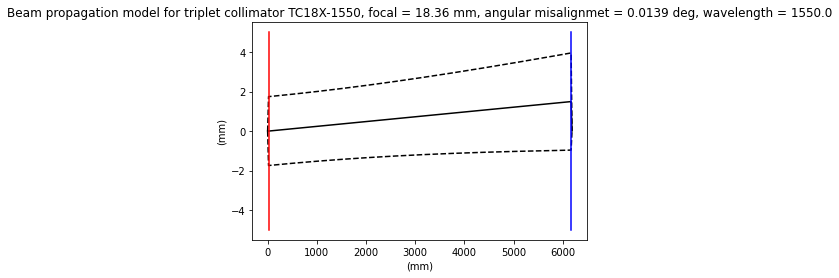

***------wavelength: 1648.0nm, MFD: 10.971094850549001um ****------


In [4]:
L_tot_all_wavelength = {}

#plot for every wavelength
for wavelength, MFD in zip(TC18APC1550_para["wavelength_range"], TC18APC1550_para["MFD_mode_solver"]):
    
    #print wavwlwngth and MFD (approximated by mode solver)
    print("***------wavelength: {}nm, MFD: {}um ****------".format(wavelength*1e9, MFD*1e6))
    
    # lateral deviation of Gaussian beam at the exit fibre end. Consider centre core, upper/lower radius
    exit_deviation = {}
    exit_deviation["centre"] = []
    exit_deviation["upper"] = []
    exit_deviation["lower"] = []

    # mode mismatch (increased beam diameter incident at exit fibre end)
    exit_MFD = []
    

    beam_diameter_on_2nd_lens_vec = []
        
    #for each angle
    for mis_angle in angular_misalignment:

        #initiation
        misalignment = Misalignment(lateral_misalignment, mis_angle)
        
    
        #Triplet collimator TC18X-1550, focal = 18.36 mm
        TC18APC1550 = ThinLens(TC18APC1550_para["focal"])
        #calculate zmax at this wavelength
        #maximum working distance to maintain collimation
        zmax = TC18APC1550.lens_maximum_working_distance(TC18APC1550_para["focal"], wavelength, MFD) #meters
    
    
        cases = {"ideal", "misaligned"}   
    
        positions = {}
        positions["centre"] = {}
        positions["upper"]  = {}
        positions["lower"]  = {}    
    
    
        for scenario in cases:
            
            #centre core that pass through lens centre does not have lateral deviation  
            beam = GaussianBeam(SMF28_fibre_para["core_beam_x0"], SMF28_fibre_para["core_beam_theta"], MFD, wavelength)
            
            #ideal scenario
            if scenario == "ideal":
                
                #propagate the ideal process of p2p link
                beam = ideal_p2p_propagation(beam, TC18APC1550, zmax, TC18APC1550_para["focal"], Nsamples)
            
            
                #store the last positions from optic axis for ideal scenario
                positions["centre"]["ideal"] = beam.centre_ray.vector[-1][0, 0]
                positions["upper"]["ideal"]  = beam.beam_radius_upper()[-1]
                positions["lower"]["ideal"]  = beam.beam_radius_lower()[-1]
            
            
            #add misalignment  
            #the misalignment is added immediately after the 1st lens
            else: 
                
                beam, beam_diameter_on_2nd_lens = angular_misalignment_p2p_propagation(beam, TC18APC1550, misalignment, zmax, TC18APC1550_para["focal"], Nsamples)
            
                positions["centre"]["misaligned"] = beam.centre_ray.vector[-1][0, 0]
                positions["upper"]["misaligned"]  = beam.beam_radius_upper()[-1]
                positions["lower"]["misaligned"]  = beam.beam_radius_lower()[-1]  
                
                beam_diameter_on_2nd_lens_vec.append(beam_diameter_on_2nd_lens) 
                
                #print(scenario)
                if (mis_angle == max(angular_misalignment) and ray_tracing_PlotON == 1 and wavelength == 1550.0e-9):
                    
                    # Plotting
                    plt.figure()
                    plt.plot(scale*np.array(beam.centre_ray.z_distance), scale *
                            np.array(beam.beam_radius_upper()), color='black', linestyle='--')
                    plt.plot(scale*np.array(beam.centre_ray.z_distance), scale *
                            np.array(beam.beam_radius_lower()), color='black', linestyle='--')
                    plt.plot(scale*np.array(beam.centre_ray.z_distance),
                            [scale*i[0, 0] for i in beam.centre_ray.vector], color='black')


                    zTx = TC18APC1550_para["focal"]
                    zRx = TC18APC1550_para["focal"]+ zmax
                    aperture_y = np.array([1, -1])*TC18APC1550_para["clear_aperture"]/2
                    aperture_x = np.array([1, 1])
                    plt.plot(aperture_x*zTx*scale, aperture_y*scale, color='red')
                    plt.plot(aperture_x*zRx*scale, aperture_y*scale, color='blue')
                    plt.xlabel('(mm)')
                    plt.ylabel('(mm)')
                    plt.title('Beam propagation model for triplet collimator TC18X-1550, focal = 18.36 mm, angular misalignmet = {} deg, wavelength = {}'.format((mis_angle*180/np.pi), (wavelength*1e9)))
                    print('---------------------------')
                    plt.show() 
                
                
                
                
                
                
          

            
            
        #exit beam diameter for this angle
        misaligned_MFD = positions["upper"]["misaligned"] - positions["lower"]["misaligned"]
        exit_MFD.append(misaligned_MFD)   
            
    
        #exit deviation for this angle
        for ray in positions.keys():

            deviation = abs(positions[ray]["misaligned"] - positions[ray]["ideal"])
            exit_deviation[ray].append(deviation)
    
    

        
        
    #calculate loss against angle for this wavelength 
    #only consider the centre ray 
    
    L_lat = []
    for d in exit_deviation["centre"]:
        L_lat.append(lateral_loss_dB(d, MFD/2))


    L_mode = []
    for w1 in exit_MFD:
        L_mode.append(mode_loss_dB(w1/2, MFD/2))
        
        
    
    L_clipping = []
    for beam_diameter in beam_diameter_on_2nd_lens_vec:
        L_clipping.append(beam_clipping_loss_dB(TC18APC1550_para["clear_aperture"]/2, beam_diameter/2))
    
    

    L_tot = [sum(x) for x in zip(L_lat, L_mode, L_clipping)]
    
    L_tot_all_wavelength[wavelength] = L_tot
    
    

 
     

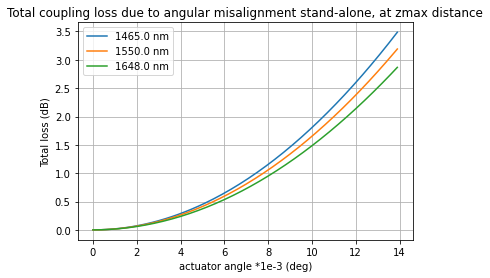

In [5]:
plt.figure()
for wavelength in L_tot_all_wavelength.keys():
    plt.plot([x*1e3 for x in angular_misalignment_deg], L_tot_all_wavelength[wavelength], label="{} nm".format(wavelength*1e9) )

plt.xlabel('actuator angle *1e-3 (deg)')
plt.ylabel('Total loss (dB)')
plt.title('Total coupling loss due to angular misalignment stand-alone, at zmax distance')
plt.legend(loc="upper left")
plt.grid()
plt.show()
    